## Building Optimal Ensembles of Neural Networks

This notebook accompanies my [TDS](https://towardsdatascience.com/ensembles-the-almost-free-lunch-in-machine-learning-91af7ebe5090) post about ensemble optimization. The structure is as follows:

[1. Settings](#section_settings)

[2. Classes and Functions](#section_classes)

[3. Training the Ensemble](#section_training)

[4. Results](#section_results)


<a id='section_settings'></a>
### 1. Settings
Import modules, set paths and random seeds.

In [1]:
import os
import numpy as np
import pandas as pd

import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

# Paths to store MNIST data and model checkpoints
DATA_PATH = "./data/"
TRAINING_PATH = "./training/"

# Set the seeds to ensure reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Create paths
for path in [DATA_PATH, TRAINING_PATH]:
    try:
        os.mkdir(path)
    except FileExistsError:
        pass

<a id='section_classes'></a>
### 2. Classes and Functions
First, define the funciton to optimize ensembles:

In [2]:
def ensemble_selector(loss_function, y_hats, y_true, init_size=1,
                      replacement=True, max_iter=100):
    """Implementation of the algorithm of Caruana et al. (2004) 'Ensemble
    Selection from Libraries of Models'. Given a loss function mapping
    predicted and ground truth values to a scalar along with a dictionary of
    models with predicted and ground truth values, constructs an optimal
    ensemble minimizing ensemble loss, by default allowing models to appear
    several times in the ensemble.

    Parameters
    ----------
    loss_function: function
        accepting two arguments - numpy arrays of predictions and true values - 
        and returning a scalar
    y_hats: dict
        with keys being model names and values being numpy arrays of predicted
        values
    y_true: np.array
        numpy array of true values, same for each model
    init_size: int
        number of models in the initial ensemble, picked by the best loss.
        Default is 1
    replacement: bool
        whether the models should be returned back to the pool of models once
        added to the ensemble. Default is True
    max_iter: int
        number of iterations for selection with replacement to perform. Only
        relevant if 'replacement' is True, otherwise iterations continue until
        the dataset is exhausted i.e.
        min(len(y_hats.keys())-init_size, max_iter). Default is 100

    Returns
    -------
    ensemble_loss: pd.Series
        with loss of the ensemble over iterations
    model_weights: pd.DataFrame
        with model names across columns and ensemble selection iterations
        across rows. Each value is the weight of a model in the ensemble

    """
    # Step 1: compute losses
    losses = dict()
    for model, y_hat in y_hats.items():
        losses[model] = loss_function(y_hat, y_true)

    # Get the initial ensemble comprised of the best models
    losses = pd.Series(losses).sort_values()
    init_ensemble = losses.iloc[:init_size].index.tolist()

    # Compute its loss
    if init_size == 1:
        # Take the best loss
        init_loss = losses.loc[init_ensemble].values[0]
        y_hat_avg = y_hats[init_ensemble[0]].copy()
    else:
        # Average the predictions over several models
        y_hat_avg = np.array(
            [y_hats[mod] for mod in init_ensemble]).mean(axis=0)
        init_loss = loss_function(y_hat_avg, y_true)

    # Define the set of available models
    if replacement:
        available_models = list(y_hats.keys())
    else:
        available_models = losses.index.difference(init_ensemble).tolist()
        # Redefine maximum number of iterations
        max_iter = min(len(available_models), max_iter)

    # Sift through the available models keeping track of the ensemble loss
    # Redefine variables for the clarity of exposition
    current_loss = init_loss
    current_size = init_size

    loss_progress = [current_loss]
    ensemble_members = [init_ensemble]
    for i in range(max_iter):
        # Compute weights for predictions
        w_current = current_size / (current_size + 1)
        w_new = 1 / (current_size + 1)

        # Try all models one by one
        tmp_losses = dict()
        tmp_y_avg = dict()
        for mod in available_models:
            tmp_y_avg[mod] = w_current * y_hat_avg + w_new * y_hats[mod]
            tmp_losses[mod] = loss_function(tmp_y_avg[mod], y_true)

        # Locate the best trial
        best_model = pd.Series(tmp_losses).sort_values().index[0]

        # Update the loop variables and record progress
        current_loss = tmp_losses[best_model]
        loss_progress.append(current_loss)
        y_hat_avg = tmp_y_avg[best_model]
        current_size += 1
        ensemble_members.append(ensemble_members[-1] + [best_model])

        if not replacement:
            available_models.remove(best_model)

    # Organize the output
    ensemble_loss = pd.Series(loss_progress, name="loss")
    model_weights = pd.DataFrame(index=ensemble_loss.index,
                                 columns=y_hats.keys())
    for ix, row in model_weights.iterrows():
        weights = pd.Series(ensemble_members[ix]).value_counts()
        weights = weights / weights.sum()
        model_weights.loc[ix, weights.index] = weights

    return ensemble_loss, model_weights.fillna(0).astype(float)

Second, define utility functions to compute cross-entropy loss and accuarcy given numpy arrays of predictions and targets:

In [3]:
def cross_entropy(predictions, targets, epsilon=1e-8):
    """Compute cross entropy given predictions as class probabilities and one-
    hot encoded ground truth labels.
    Parameters
    ----------
    predictions: np.array
        (num examples, num_classes) of predicted class probabilities
    targets: np.array
        (num examples, num_classes) of one-hot encoded true class labels
    epsilon: float
     a constant to clip predicted probabilities to avoid taking log of zero
    Returns
    -------
    cross_entropy: float
        cross entropy of the inputs
    """
    predictions = np.clip(predictions, epsilon, 1-epsilon)
    return (-np.log(predictions) * targets).sum(axis=1).mean()


def accuracy(predictions, targets, one_hot_targets=True):
    """Compute accuracy given arrays of predictions and targets.

    Parameters
    predictions: np.array
        (num examples, num_classes) of predicted class probabilities/scores
    targets: np.array
        (num examples, num_classes) of one hot encoded true class labels if
        'one_hot_targets' is True, or true class indices if it is False
    one_hot_targets: bool
        whether the target are in one-hot or class index format. Default is
        True

    Returns
    -------
    accuracy: float
        accuracy of predictions

    """
    if one_hot_targets:
        return (predictions.argmax(axis=1) == targets.argmax(axis=1)).mean()
    else:
        return (predictions.argmax(axis=1) == targets).mean()

Finally, define the multilayer perceptron class for MNIST:

In [4]:
class MNISTMLP(nn.Module):
    """A simple MLP for MNIST.

    Class Attributes
    ----------------
    n_classes: int
        number of classes, corresponds to dimensionality of the output layer

    """
    n_classes = 10

    def __init__(self, d_in, n_layers, units, dropout, activation=nn.ReLU):
        """Instantiate.

        Parameters
        ----------
        d_in: int
            dimension of input vector
        n_layers: int
            number of hidden layers
        units: iterable
            of length equal number of layers with elements being integers
            specifying number of units in each layer
        dropout: float or None
            dropout probability, if None, no dropout is applied
        activation: torch.nn.modules.activation
            hidden layer activation function: 'nn.ReLU', 'nn.GELU', etc.
            Default is 'nn.ReLU'

        """
        super().__init__()

        # Check if units and layers match
        assert len(units) == n_layers

        # Assign parameters as attributes
        self.d_in = d_in
        self.n_layers = n_layers
        self.units = units
        self.activation = activation

        # Dropout operation
        if dropout is None:
            self.dropout = None
        else:
            self.dropout = nn.Dropout(p=dropout)

        # Construct intermediate layers
        if dropout is None:
            layers = [nn.Linear(d_in, units[0]), self.activation()]
            if n_layers > 1:
                for i, u in enumerate(units):
                    if i > 0:
                        layers.extend([nn.Linear(units[i-1], units[i]),
                                       self.activation()])
        else:
            layers = [nn.Linear(d_in, units[0]), self.activation(),
                      self.dropout]
            if n_layers > 1:
                for i, u in enumerate(units):
                    if i > 0:
                        layers.extend([nn.Linear(units[i-1], units[i]),
                                       self.activation(), self.dropout])

        # Final layer: outputs - raw scores
        self.final_layer = [nn.Linear(units[-1], self.n_classes)]
        layers.extend(self.final_layer)

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        """Forward pass."""
        flattened_x = x.view(-1, self.d_in)
        return self.layers(flattened_x)

<a id='section_training'></a>
### 3. Training the Ensemble
Now when we are done with settings and definitions, let's do some more settings and definitions, this time for training the ensemble candidates. We will train 10 identical MLPs (with differrent initializations) for only 3 epochs (to make the impact of ensembling more dramatic), using 25% of the training data for validation. The network is a vanilla MLP with 3 hidden layers of 100 units each, trained with minibatches of 32 examples, learning rate of 0.001 and no dropout.

In [5]:
models_to_train = 10  # train this many models
max_epochs = 3        # for this many epochs
val_spilt = 0.25      # % of the torch MNIST train set for validation

# Define model names 
model_names = ["M" + str(m) for m in range(models_to_train)]

# Hyperparameters defining network architecture and training
n_layers = 3 
units = [100, 100, 100]
batch_size = 32
learning_rate = 1e-3
dropout = None

Now, load the MNIST data, and randomly split the 60k of training examples into training and validation sets.

In [6]:
# Load the data
dataset_train = datasets.MNIST(DATA_PATH, train=True, download=True,
                               transform=transforms.ToTensor())
dataset_test = datasets.MNIST(DATA_PATH, train=False, download=True,
                              transform=transforms.ToTensor())

# Prepare the training and validation samples
all_indices = list(range(len(dataset_train)))          # enumerate samples
np.random.shuffle(all_indices)                         # shuffle
split = int(np.floor(val_spilt * len(dataset_train)))  # train/val samples
train_idx = all_indices[split:]
val_idx = all_indices[:split]

Next, wrap the datasets into torch `DataLoader`s, note that we set batch size to number of examples for validation and test sets in order to get the entire datasets as tensors, thus avoiding unnecessary loops.

In [7]:
# Define dataloaders
train_loader = DataLoader(dataset_train, batch_size=batch_size,
                          sampler=SubsetRandomSampler(indices=train_idx))

# Full batch for the validation and test loaders
val_loader = DataLoader(dataset_train, batch_size=len(val_idx),
                        sampler=SubsetRandomSampler(indices=val_idx))
test_loader = DataLoader(dataset_test, batch_size=len(dataset_test),
                         shuffle=False)

# Since both validation and test use full batch, fetch the features and
# targets as tensors
for batch in val_loader:
    x_val, y_val = batch[0], batch[1]
for batch in test_loader:
    x_test, y_test = batch[0], batch[1]

We train each model for `max_epochs` recording loss and accuracy on the train and validation sets, and saving the checkpoints after each epoch.

In [8]:
# Loss function is negative log-likelihood/cross-entropy
loss_fn = nn.CrossEntropyLoss()

# Train a pool of ensemble candidates
for model_name in model_names:

    # Define the model
    mlp = MNISTMLP(d_in=dataset_train[0][0].reshape(-1).shape[0],
                   n_layers=n_layers, units=units, dropout=None)
    optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate)

    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    for epoch in range(max_epochs):

        # Training loop
        mlp.train()
        epoch_loss = []
        epoch_acc = []
        for x_batch, y_true_batch in train_loader:
            # Forward pass
            y_hat = mlp(x_batch)

            # Compute loss
            loss = loss_fn(y_hat, y_true_batch)

            # Backpropagate and update the weights
            loss.backward()
            optimizer.step()

            # Reset gradients
            optimizer.zero_grad()

            # Append loss and accuracy estimates
            epoch_loss.append(loss.item())
            epoch_acc.extend(
                (y_hat.argmax(dim=1) == y_true_batch)
                .detach().numpy().tolist()
                )

        # Compute metrics for this epoch
        train_loss.append(np.array(epoch_loss).mean())
        train_acc.append(np.array(epoch_acc).mean())

        # Process validation set
        mlp.eval()
        y_hat = mlp(x_val)
        loss = loss_fn(y_hat, y_val)
        val_loss.append(loss.item())
        val_acc.append(
            (y_hat.argmax(dim=1) == y_val).float().mean().item()
            )

        print(
            "Model Name {}, Epoch {}:\n"
            "Train Loss: {:4.4f}, Train Acc: {:4.4f} "
            "Val Loss: {:4.4f}, Val Acc: {:4.4f}".format(
                model_name, epoch,
                train_loss[-1], train_acc[-1],
                val_loss[-1], val_acc[-1])
            )

        # Save the checkpoint
        torch.save({
            "epoch": epoch,
            "model_state_dict": mlp.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "history": pd.DataFrame(
                {"train_loss": train_loss, "train_acc": train_acc,
                 "val_loss": val_loss, "val_acc": val_acc}).astype(float),
            "train_loss": train_loss[-1],
            "train_acc": train_acc[-1],
            "val_loss": val_loss[-1],
            "val_acc": val_acc[-1]
            },
            TRAINING_PATH + model_name + "_epoch_" + str(epoch) + ".p")

Model Name M0, Epoch 0:
Train Loss: 0.3389, Train Acc: 0.8988 Val Loss: 0.1844, Val Acc: 0.9430
Model Name M0, Epoch 1:
Train Loss: 0.1396, Train Acc: 0.9576 Val Loss: 0.1214, Val Acc: 0.9641
Model Name M0, Epoch 2:
Train Loss: 0.1005, Train Acc: 0.9682 Val Loss: 0.1264, Val Acc: 0.9634
Model Name M1, Epoch 0:
Train Loss: 0.3515, Train Acc: 0.8943 Val Loss: 0.1858, Val Acc: 0.9447
Model Name M1, Epoch 1:
Train Loss: 0.1442, Train Acc: 0.9562 Val Loss: 0.1462, Val Acc: 0.9548
Model Name M1, Epoch 2:
Train Loss: 0.1003, Train Acc: 0.9685 Val Loss: 0.1097, Val Acc: 0.9675
Model Name M2, Epoch 0:
Train Loss: 0.3409, Train Acc: 0.8970 Val Loss: 0.1903, Val Acc: 0.9441
Model Name M2, Epoch 1:
Train Loss: 0.1432, Train Acc: 0.9563 Val Loss: 0.1352, Val Acc: 0.9578
Model Name M2, Epoch 2:
Train Loss: 0.0992, Train Acc: 0.9690 Val Loss: 0.1451, Val Acc: 0.9567
Model Name M3, Epoch 0:
Train Loss: 0.3321, Train Acc: 0.9003 Val Loss: 0.1745, Val Acc: 0.9462
Model Name M3, Epoch 1:
Train Loss: 0.13

In the training directory there is now a bunch of checkpoints for each model: 

In [9]:
os.listdir(TRAINING_PATH)[:10]

['M0_epoch_0.p',
 'M0_epoch_1.p',
 'M0_epoch_2.p',
 'M1_epoch_0.p',
 'M1_epoch_1.p',
 'M1_epoch_2.p',
 'M2_epoch_0.p',
 'M2_epoch_1.p',
 'M2_epoch_2.p',
 'M3_epoch_0.p']

Next, for each model we gather the results for the best performing epoch (according to the validation loss), computing losses and accuracies on the validation and test sets, and storing validation set predictions.

In [10]:
# For each model pick the checkpoint with the lowest validation loss, then:
# 1. compute losses and accuracies on the validation and test set
# 2. get predictions on the validation set
trained_models = {}
metrics = {}
y_hats_val = {}
y_hats_test = {}
for model_name in model_names:
    # Load the last checkpoint
    last_checkpoint = torch.load(
        TRAINING_PATH + model_name + "_epoch_" + str(max_epochs-1) + ".p")

    # Find the best checkpoint by validation loss
    best_by_val_loss = \
        last_checkpoint["history"].sort_values("val_loss").index[0]
    best_checkpoint = torch.load(
        TRAINING_PATH + model_name + "_epoch_" +
        str(best_by_val_loss) + ".p"
        )

    # Restore the best checkpoint
    mlp = MNISTMLP(d_in=dataset_train[0][0].reshape(-1).shape[0],
                   n_layers=n_layers, units=units, dropout=dropout)
    mlp.load_state_dict(best_checkpoint["model_state_dict"])
    mlp.eval()

    # Compute predictions on the validation and test sets, compute the
    # metrics for the latter (validation stuff has already been saved)
    y_hat_val = mlp(x_val)
    y_hat_test = mlp(x_test)

    test_loss = loss_fn(y_hat_test, y_test).item()
    test_acc = (y_hat_test.argmax(dim=1) == y_test).float().mean().item()

    # Store the outputs
    trained_models[model_name] = mlp
    metrics[model_name] = {
        "val_loss": best_checkpoint["val_loss"],
        "val_acc": best_checkpoint["val_acc"],
        "test_loss": test_loss,
        "test_acc": test_acc
        }
    # Convert predictions to class probabilities
    y_hats_val[model_name] = y_hat_val.softmax(dim=1).detach().numpy()
    y_hats_test[model_name] = y_hat_test.softmax(dim=1).detach().numpy()

# Convert the metrics dict to a dataframe
metrics = pd.DataFrame(metrics).T.astype(float)

<a id='section_results'></a>
### 4. Results

Now we have everything to start building ensembles. Let's examine the performance of the individual models first: 

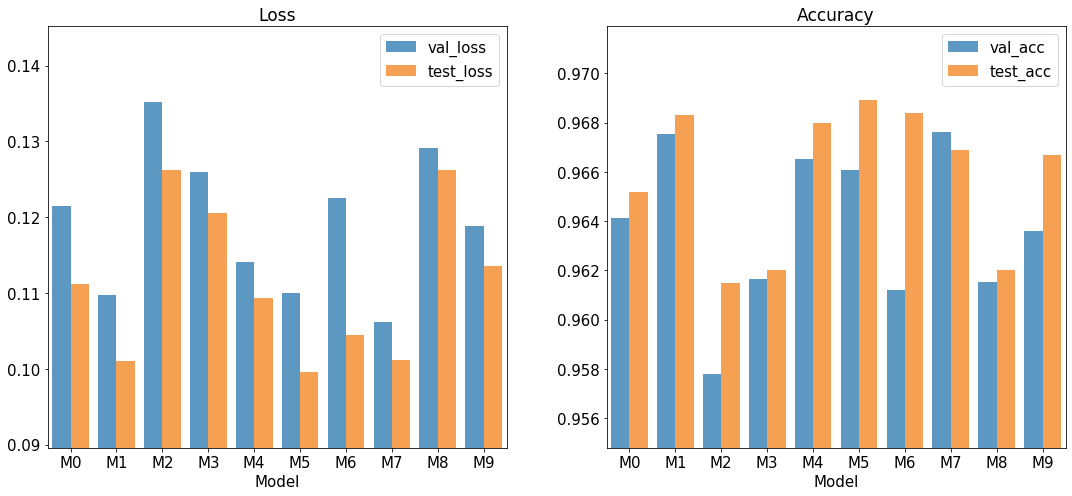

In [11]:
# Separate dataframes for losses and accuracies
metrics_loss = metrics.filter(like="loss").stack().reset_index()
metrics_loss.columns = ["model", "val/test", "loss"]

metrics_acc = metrics.filter(like="acc").stack().reset_index()
metrics_acc.columns = ["model", "val/test", "acc"]

# Plot losses and accuracies
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.barplot(x="model", y="loss", hue="val/test", data=metrics_loss,
            alpha=0.75, saturation=0.90, palette=["#1f77b4", "#ff7f0e"],
            ax=ax[0])
sns.barplot(x="model", y="acc", hue="val/test", data=metrics_acc,
            alpha=0.75, saturation=0.90, palette=["#1f77b4", "#ff7f0e"],
            ax=ax[1])

ax[0].set_ylim(metrics_loss["loss"].min() - 1e-2,
               metrics_loss["loss"].max() + 1e-2)
ax[1].set_ylim(metrics_acc["acc"].min()-3e-3,
               metrics_acc["acc"].max()+3e-3)

ax[0].set_title("Loss", fontsize=17)
ax[1].set_title("Accuracy", fontsize=17)

for x in ax:
    x.xaxis.set_tick_params(rotation=0, labelsize=15)
    x.yaxis.set_tick_params(rotation=0, labelsize=15)
    x.set_xlabel("Model", visible=True, fontsize=15)
    x.set_ylabel("", visible=False)

    handles, labels = x.get_legend_handles_labels()
    x.legend(handles=handles, labels=labels, fontsize=15)

fig.tight_layout(w_pad=5)

Note, that since the models were trained for 3 epochs only, the classification accuracy is rather poor, even for the MLP architecture.

Let's build an ensmble minimizing the validation loss, by drawing the models with replacement and adding them to the ensemble one-by-one, minimizing the loss of the ensemble on the validation set.

In [12]:
# One-hot encoded validation labels
y_true_one_hot_val = np.eye(10)[y_val.numpy()]

ensemble_loss, model_weights = ensemble_selector(
    loss_function=cross_entropy, y_hats=y_hats_val,
    y_true=y_true_one_hot_val, init_size=1, replacement=True, max_iter=10
    )

`ensemble_loss` is a series of ensemble losses at each iteration of the algorithm, while `ensemble_weights` is a dataframe of the corresponding weights:

In [13]:
print(ensemble_loss)

0     0.106177
1     0.091242
2     0.088850
3     0.087228
4     0.086688
5     0.086664
6     0.086605
7     0.086684
8     0.086654
9     0.086604
10    0.086574
Name: loss, dtype: float64


In [14]:
print(model_weights)

     M0        M1   M2   M3        M4        M5   M6        M7   M8        M9
0   0.0  0.000000  0.0  0.0  0.000000  0.000000  0.0  1.000000  0.0  0.000000
1   0.0  0.000000  0.0  0.0  0.000000  0.500000  0.0  0.500000  0.0  0.000000
2   0.0  0.000000  0.0  0.0  0.000000  0.333333  0.0  0.333333  0.0  0.333333
3   0.0  0.000000  0.0  0.0  0.250000  0.250000  0.0  0.250000  0.0  0.250000
4   0.0  0.200000  0.0  0.0  0.200000  0.200000  0.0  0.200000  0.0  0.200000
5   0.0  0.166667  0.0  0.0  0.166667  0.166667  0.0  0.333333  0.0  0.166667
6   0.0  0.142857  0.0  0.0  0.142857  0.285714  0.0  0.285714  0.0  0.142857
7   0.0  0.125000  0.0  0.0  0.250000  0.250000  0.0  0.250000  0.0  0.125000
8   0.0  0.111111  0.0  0.0  0.222222  0.222222  0.0  0.222222  0.0  0.222222
9   0.0  0.100000  0.0  0.0  0.200000  0.200000  0.0  0.300000  0.0  0.200000
10  0.0  0.181818  0.0  0.0  0.181818  0.181818  0.0  0.272727  0.0  0.181818


Out of 10 models only 5 ever receive a non-zero weight in the ensemble. The figure below plots weights of the ensemble's constituents as a function of ensemble optimization steps with lighter hues corresponding to lower average weights over all iterations. The ensemble is initialized with the strongest single model __M7__ and then sequentially adds models to minimize the loss on the validation set. Once no new model can improve the loss any further, the algorithm continues to add the models that are already in the ensemble increasing their weight.

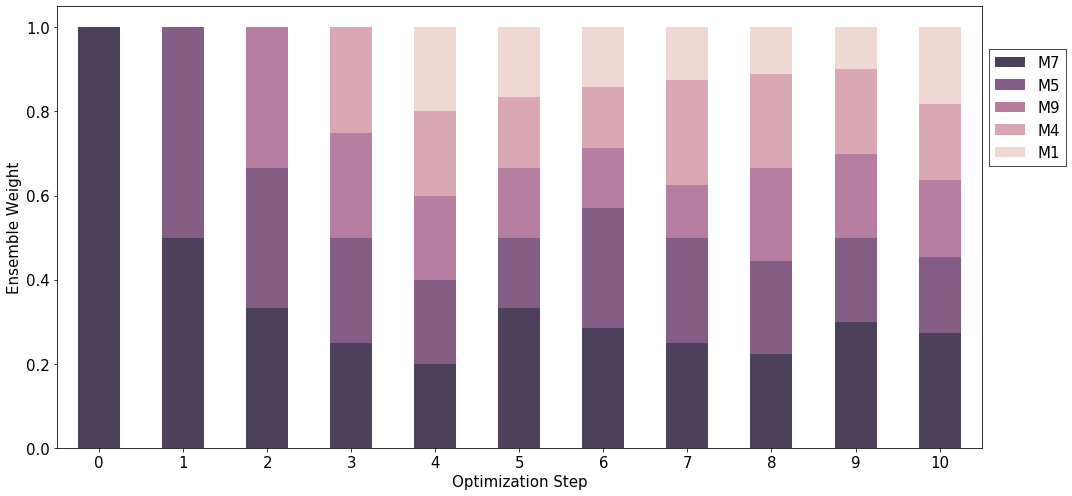

In [15]:
# Locate non-zero weights and sort models by their average weight
weights_to_plot = model_weights.loc[:, (model_weights != 0).any()]
weights_to_plot = weights_to_plot[
    weights_to_plot.mean().sort_values(ascending=False).index]

# A palette corresponding to the number of models with non-zero weights
palette = sns.cubehelix_palette(weights_to_plot.shape[1], reverse=True)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
weights_to_plot.plot(kind="bar", stacked=True, color=palette, ax=ax,
                     alpha=0.85)

ax.margins(x=0.0)
ax.set_xlabel("Optimization Step", fontsize=15, visible=True)
ax.set_ylabel("Ensemble Weight", fontsize=15, visible=True)
ax.yaxis.set_tick_params(rotation=0, labelsize=15)
ax.xaxis.set_tick_params(rotation=0, labelsize=15)
ax.legend(loc="best", bbox_to_anchor=(1, 0.92),
          frameon=True, edgecolor="k", fancybox=False,
          framealpha=0.7, shadow=False, ncol=1, fontsize=15)
fig.tight_layout()

To check how the test set performance of the ensemble, compute test set prediction applying the optimal weights:

In [16]:
# Use the weights to construct the ensemble on the test set
y_true_one_hot_test = np.eye(10)[y_test.numpy()]

# Compute the test loss for each ensemble iteration
ensemble_loss_test = []
for _, row in model_weights.iterrows():
    # Compute test prediction for this iteration of ensemble weights
    tmp_y_hat = np.array(
        [y_hats_test[model_name] * weight
         for model_name, weight in row.items()]
        ).sum(axis=0)

    ensemble_loss_test.append(
        cross_entropy(tmp_y_hat, y_true_one_hot_test))
ensemble_loss_test = pd.Series(ensemble_loss_test)

We will compare the optimized ensemble to two baselines: the best model by performance on the validation set, and a simple ensemble which assigns an equal weight to each model in the pool. We already have the data for the former, so let's construct the equally-weighted ensembles:

In [17]:
# Compute loss of an ensemble which equally weights each model in the pool
y_val_avg = np.array([_y for m, _y in y_hats_val.items()]).mean(axis=0)
ens_loss_val_avg = cross_entropy(y_val_avg, y_true_one_hot_val)

y_test_avg = np.array([_y for m, _y in y_hats_test.items()]).mean(axis=0)
ens_loss_test_avg = cross_entropy(y_test_avg, y_true_one_hot_test)

The figure below plots the ensemble losses as a funciton of the number of iterations for the validation and test sets on the left and right panels respectively. On each subplot the solid blue lines shows the loss of the optimal ensemble as iterations progress, while the black and red solid lines represent the losses of the best model and equally-weighted ensemble respectively.   

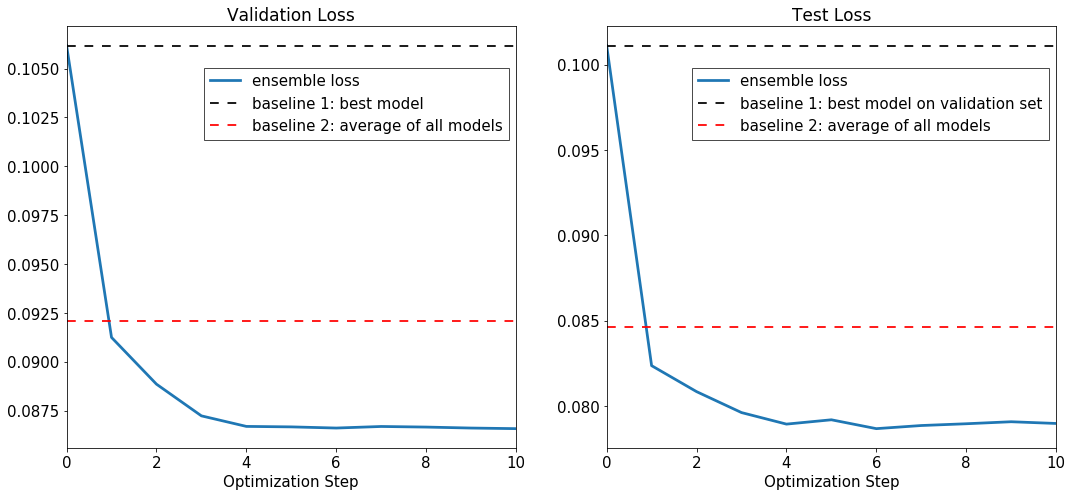

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7), sharey=False)
ax[0].plot(ensemble_loss, color="#1f77b4", lw=2.75,
           label="ensemble loss")
ax[0].plot(pd.Series(ensemble_loss[0], ensemble_loss.index),
           color="k", lw=1.75, ls="--", dashes=(5, 5),
           label="baseline 1: best model")
ax[0].plot(pd.Series(ens_loss_val_avg, ensemble_loss.index),
           color="r", lw=1.75, ls="--", dashes=(5, 5),
           label="baseline 2: average of all models")

ax[1].plot(ensemble_loss_test, color="#1f77b4", lw=2.75,
           label="ensemble loss")
ax[1].plot(pd.Series(ensemble_loss_test[0], ensemble_loss_test.index),
           color="k", lw=1.75, ls="--", dashes=(5, 5),
           label="baseline 1: best model on validation set")
ax[1].plot(pd.Series(ens_loss_test_avg, ensemble_loss.index),
           color="r", lw=1.75, ls="--", dashes=(5, 5),
           label="baseline 2: average of all models")

ax[0].set_title("Validation Loss", fontsize=17)
ax[1].set_title("Test Loss", fontsize=17)

for x in ax:
    x.margins(x=0.0)
    x.set_xlabel("Optimization Step", fontsize=15, visible=True)
    x.set_ylabel("", fontsize=15, visible=False)
    x.yaxis.set_tick_params(labelsize=15)
    x.xaxis.set_tick_params(labelsize=15)
    x.legend(loc="upper right", bbox_to_anchor=(1, 0.92),
             frameon=True, edgecolor="k", fancybox=False,
             framealpha=0.7, shadow=False, ncol=1, fontsize=15)
fig.tight_layout(w_pad=3.14)

Of course, the ensemble optimization is flexible enough to accomodate other loss functions, for instance we can build an ensemble that maximizes accuracy:

In [19]:
# Accuracy-maximizing ensemble on the validation set
ensemble_acc, model_weights_acc = ensemble_selector(
    loss_function=lambda p, t: -accuracy(p, t),  # - for minimization
    y_hats=y_hats_val, y_true=y_true_one_hot_val,
    init_size=1, replacement=True, max_iter=10
    )
ensemble_acc = -ensemble_acc  # back to positive domain

# Compute accuracy of the equally weighted ensemble
ens_acc_val_avg = accuracy(y_val_avg, y_true_one_hot_val)

# Apply the weights to the predicitons on the test set
# Compute the test loss for each ensemble iteration
ensemble_acc_test = []
for _, row in model_weights_acc.iterrows():
    # Compute test prediction for this iteration of ensemble weights
    tmp_y_hat = np.array(
        [y_hats_test[model_name] * weight
         for model_name, weight in row.items()]
        ).sum(axis=0)

    ensemble_acc_test.append(
        accuracy(tmp_y_hat, y_true_one_hot_test))
ensemble_acc_test = pd.Series(ensemble_acc_test)

# Equally-weighted ensemble
ens_acc_test_avg = accuracy(y_test_avg, y_true_one_hot_test)

The figure below repeats the analysis from the previous figure for accuracies:

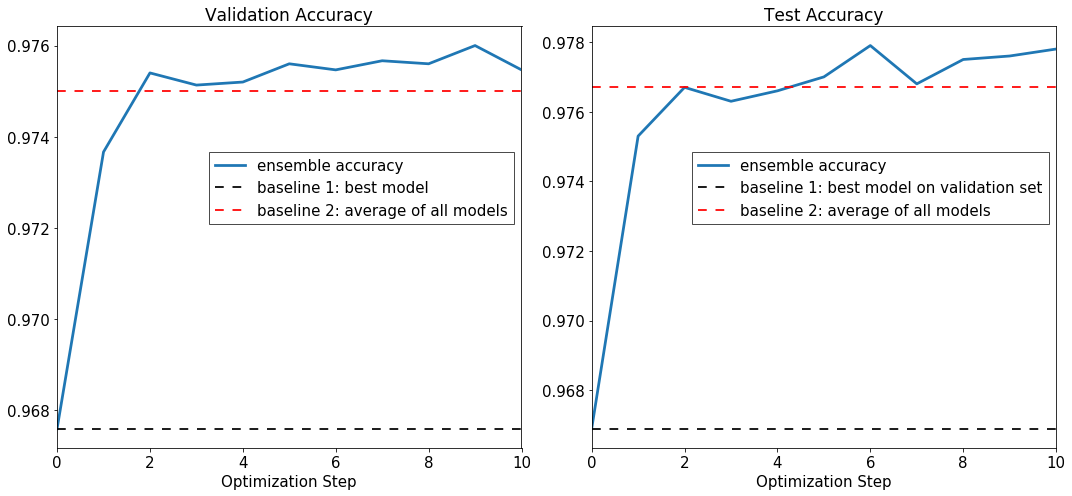

In [20]:
    fig, ax = plt.subplots(1, 2, figsize=(15, 7), sharey=False)
    ax[0].plot(ensemble_acc, color="#1f77b4", lw=2.75,
               label="ensemble accuracy")
    ax[0].plot(pd.Series(ensemble_acc[0], ensemble_acc.index),
               color="k", lw=1.75, ls="--", dashes=(5, 5),
               label="baseline 1: best model")
    ax[0].plot(pd.Series(ens_acc_val_avg, ensemble_loss.index),
               color="r", lw=1.75, ls="--", dashes=(5, 5),
               label="baseline 2: average of all models")

    ax[1].plot(ensemble_acc_test, color="#1f77b4", lw=2.75,
               label="ensemble accuracy")
    ax[1].plot(pd.Series(ensemble_acc_test[0], ensemble_loss_test.index),
               color="k", lw=1.75, ls="--", dashes=(5, 5),
               label="baseline 1: best model on validation set")
    ax[1].plot(pd.Series(ens_acc_test_avg, ensemble_loss.index),
               color="r", lw=1.75, ls="--", dashes=(5, 5),
               label="baseline 2: average of all models")

    ax[0].set_title("Validation Accuracy", fontsize=17)
    ax[1].set_title("Test Accuracy", fontsize=17)

    for x in ax:
        x.margins(x=0.0)
        x.set_xlabel("Optimization Step", fontsize=15, visible=True)
        x.set_ylabel("", fontsize=15, visible=False)
        x.yaxis.set_tick_params(labelsize=15)
        x.xaxis.set_tick_params(labelsize=15)
        x.legend(loc="upper right", bbox_to_anchor=(1, 0.72),
                 frameon=True, edgecolor="k", fancybox=False,
                 framealpha=0.7, shadow=False, ncol=1, fontsize=15)
    fig.tight_layout()